In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools


# Transformers

The **Transformer** architecture includes an encoder and a decoder.

*   The **encoder** consists of N encoder layers (6 in the original paper, but this is adjustable).
*   The **decoder** contains M decoder layers (for simplicity of description we assume $M=N$, but in the example below $N=6, M=1$).

There are also connections between encoder layers and decoder layers. For clarity, the figure below should display "encoder layers" and "decoder layers," instead of the less specific "encoders" and "decoders".


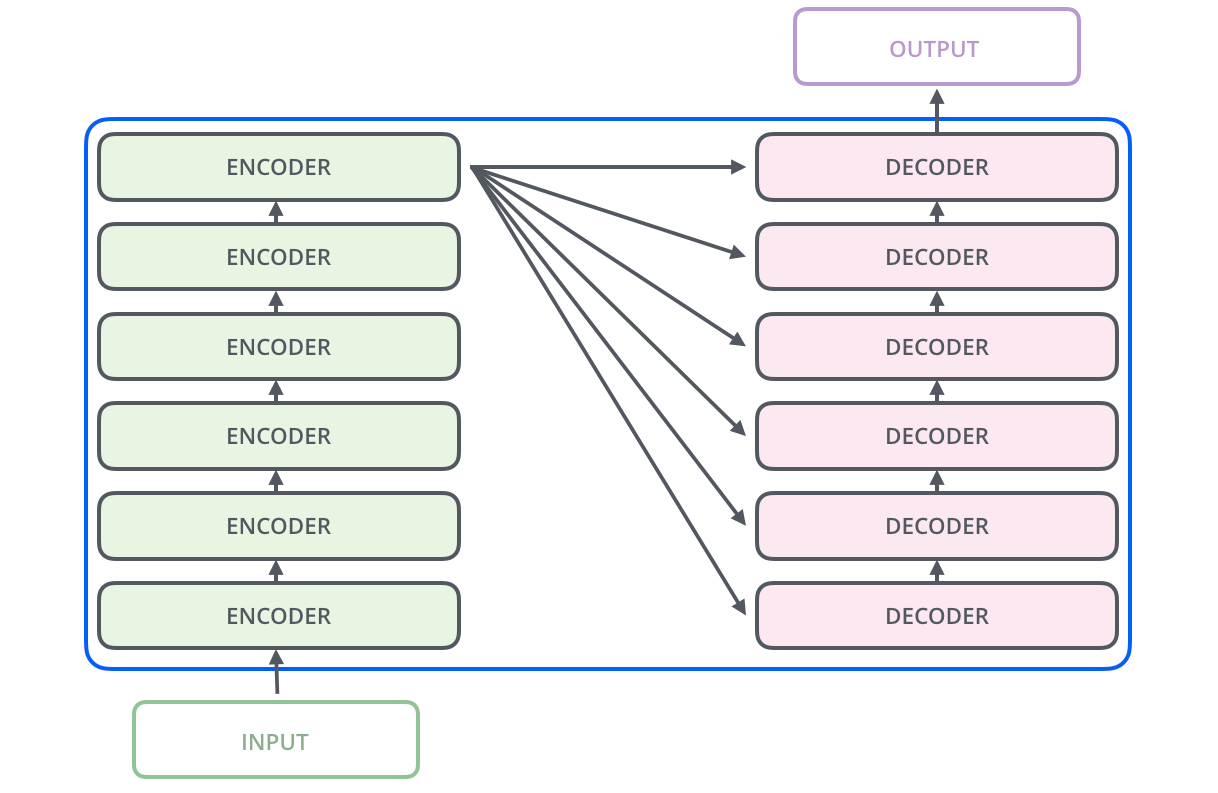

**Encoder layers** in the Transformer have identical structures but distinct weights. Each encoder layer consists of

*  a **self-attention layer**, which processes input words in context,
*  followed by a position-wise **feed-forward network**.

The **decoder** mirrors this, adding between them an **attention layer** to focus on relevant encoder outputs. "Encoder-Decoder Attention" in the figure below is commonly referred to as **Cross-Attention**.

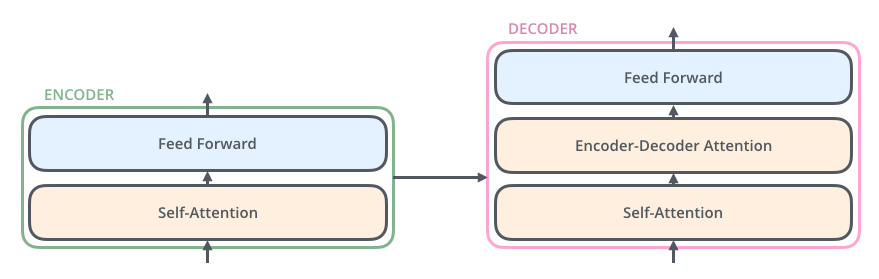

This is a simplified overview. In practice, layers include **normalization** and **residual connections** for stability. <font color='red'>See "Transformer Layers" Section below for details.</font>

In the example below the FNN architecture follows a simple pattern: $$\text{Linear } + \text{ ReLU } + \text{ Linear } + \text{ Dropout}.$$

In practice, FNNs can have more complex architectures.






In [ ]:
class TransformerFFN(nn.Module):
    def __init__(self, in_dim, dim_hidden, out_dim, dropout):
        super().__init__()
        self.dropout = dropout
        self.act = F.relu
        self.lin1 = nn.Linear(in_dim, dim_hidden)
        self.lin2 = nn.Linear(dim_hidden, out_dim)

    def forward(self, input):
        x = self.lin1(input)
        x = self.act(x)
        x = self.lin2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return x

##  Self-Attention

This section explains **self-attention**. For each input embedding, we generate $3$ vectors:

1.  a <font color='pink'>**Query**</font> vector,
2.  a <font color='orange'>**Key**</font> vector,
3.  a <font color='blue'>**Value**</font> vector.

These vectors have a dimensionality of 64, while the original embedding and encoder vectors are 512-dimensional. This dimensionality reduction helps maintain consistent computation in multi-head attention. In matrix form, we create <font color='pink'>**Query**</font>, <font color='orange'>**Key**</font> and <font color='blue'>**Value**</font> matrices by multiplying the embedding matrix with trained weight matrices.


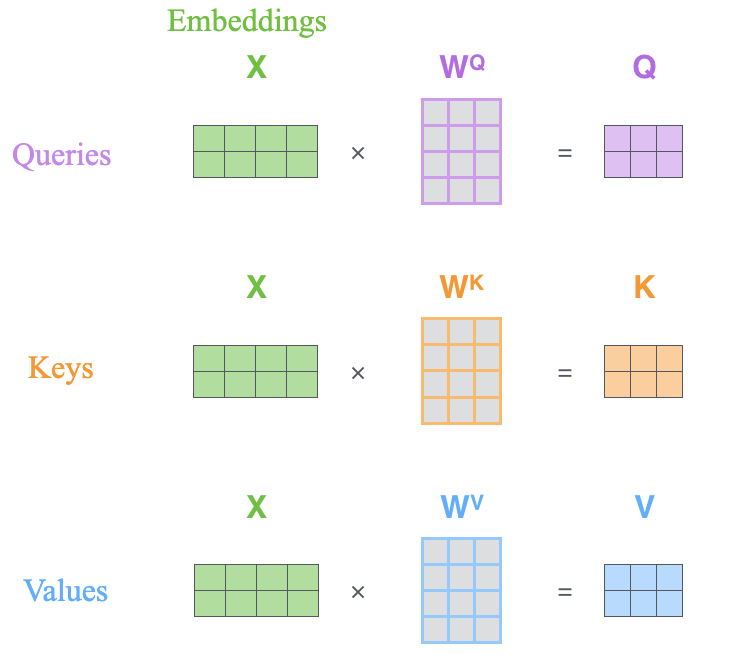

Next, self-attention is calculated as follows:

1. First, we score each word against the target word by taking the dot product of their <font color='pink'>**Query**</font> and <font color='orange'>**Key**</font> vectors. This score determines *attention focus*.
2. We scale the scores (*divide by $8$*, i.e. the square root of the key dimension $d_k = 64$). This leads to having more stable gradients.
3. We apply `Softmax` for normalization.
4. We multiply each <font color='blue'>**Value**</font> vector by its softmax score.
5. Finally, we sum the weighted value vectors to produce the self-attention output.

$$\operatorname{Self-Attention}(Q,K,V)=\operatorname{Softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V.$$


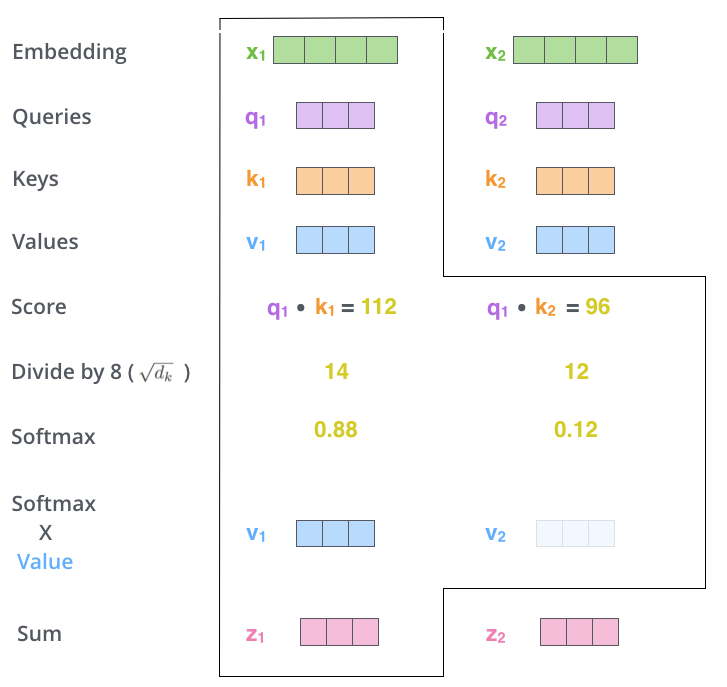


In matrix form we calculate it as follows:

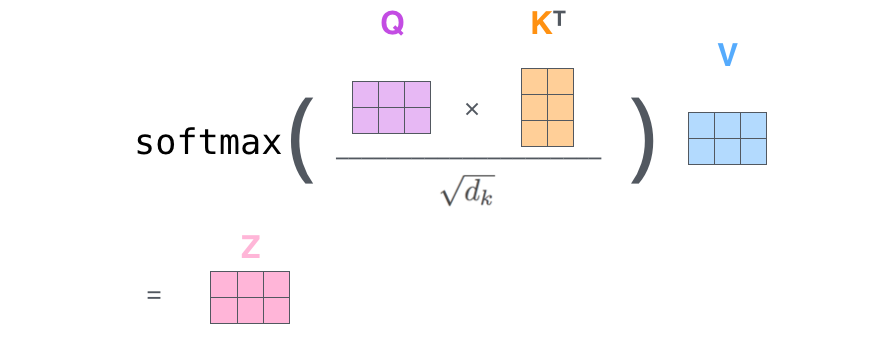

In [ ]:
class MultiHeadAttention(nn.Module):

    NEW_ID = itertools.count()

    def __init__(self, n_heads, dim, src_dim, dropout):
        super().__init__()
        self.layer_id = next(MultiHeadAttention.NEW_ID)
        self.dim = dim
        self.src_dim = src_dim
        self.n_heads = n_heads
        self.dropout = dropout
        assert self.dim % self.n_heads == 0

        self.q_lin = nn.Linear(dim, dim)
        self.k_lin = nn.Linear(src_dim, dim)
        self.v_lin = nn.Linear(src_dim, dim)
        self.out_lin = nn.Linear(dim, dim)

    def forward(self, input, mask, kv=None, use_cache=False):
        """
        Self-attention (if kv is None)
        or attention over source sentence (provided by kv).
        Input is (bs, qlen, dim)
        Mask is (bs, klen) (non-causal) or (bs, klen, klen)
        """
        assert not (use_cache and self.cache is None)


        ##################################
        # 1. Calculation of dimensions
        ##################################

        bs, qlen, dim = input.size()

        # If self-attention
        if kv is None:
            klen = qlen if not use_cache else self.cache["slen"] + qlen
        else:
            klen = kv.size(1)
        assert dim == self.dim, "Dimensions do not match: %s input vs %s configured" % (
            dim,
            self.dim,
        )
        n_heads = self.n_heads
        dim_per_head = dim // n_heads
        mask_reshape = (bs, 1, qlen, klen) if mask.dim() == 3 else (bs, 1, 1, klen)

        ##################################
        # 2. Q, K, V
        ##################################

        def shape(x):
            """  projection """
            # changes size of tensor to (bs, n_heads, *, dim_per_head)
            return x.view(bs, -1, self.n_heads, dim_per_head).transpose(1, 2)


        q = shape(self.q_lin(input))  # (bs, n_heads, qlen, dim_per_head)
        if kv is None:
            k = shape(self.k_lin(input))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v_lin(input))  # (bs, n_heads, qlen, dim_per_head)
        elif not use_cache or self.layer_id not in self.cache:
            k = v = kv
            k = shape(self.k_lin(k))  # (bs, n_heads, qlen, dim_per_head)
            v = shape(self.v_lin(v))  # (bs, n_heads, qlen, dim_per_head)

        ##################################
        # 3. Caching K and V
        ##################################

        if use_cache:
            if self.layer_id in self.cache:
                if kv is None:
                    k_, v_ = self.cache[self.layer_id]
                    k = torch.cat([k_, k], dim=2)  # (bs, n_heads, klen, dim_per_head)
                    v = torch.cat([v_, v], dim=2)  # (bs, n_heads, klen, dim_per_head)
                else:
                    k, v = self.cache[self.layer_id]
            self.cache[self.layer_id] = (k, v)

        ##################################
        # 4. Output from Q, K, V
        ##################################

        # Steps 1 and 2
        q = q / math.sqrt(dim_per_head)  # (bs, n_heads, qlen, dim_per_head)
        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, qlen, klen)

        ##################
        # Attention mask (see explanation below)
        ##################

        mask = (
            (mask == 0).view(mask_reshape).expand_as(scores)
        )  # (bs, n_heads, qlen, klen)
        scores.masked_fill_(mask, -float("inf"))  # (bs, n_heads, qlen, klen)

        # Step 3
        weights = F.softmax(scores.float(), dim=-1).type_as(
            scores
        )  # (bs, n_heads, qlen, klen)

        # Add Dropout
        weights = F.dropout(
            weights, p=self.dropout, training=self.training
        )  # (bs, n_heads, qlen, klen)

        # Steps 4 and 5
        context = torch.matmul(weights, v)  # (bs, n_heads, qlen, dim_per_head)

        def unshape(x):
            """  compute context """
            # we use it to change (bs, n_heads, qlen, dim_per_head) tensor
            # into a (bs, qlen, dim) tensor
            return (
                x.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * dim_per_head)
            )
            # tensor.contiguous() will create a copy of the tensor, and
            # the element in the copy will be stored in the memory in a contiguous way.
            # The contiguous() function is usually required when we first transpose() a tensor and then reshape (view) it.

        context = unshape(context)  # (bs, qlen, dim)

        # We save weight if we want to check them
        if TransformerModel.STORE_OUTPUTS and not self.training:
            self.outputs = weights.detach().cpu()

        return self.out_lin(context)

**Multi-head attention** enhances self-attention by providing two key benefits: improved focus on different positions and the creation of multiple representation subspaces. This is accomplished by *using multiple sets* of <font color='pink'>**Query**</font>, <font color='orange'>**Key**</font> and <font color='blue'>**Value**</font> weight matrices, each initialized differently. After calculating self-attention with each head, the resulting matrices are concatenated to form a larger matrix, which is then linearly transformed using a weight matrix ($W^O$) to produce the final output.

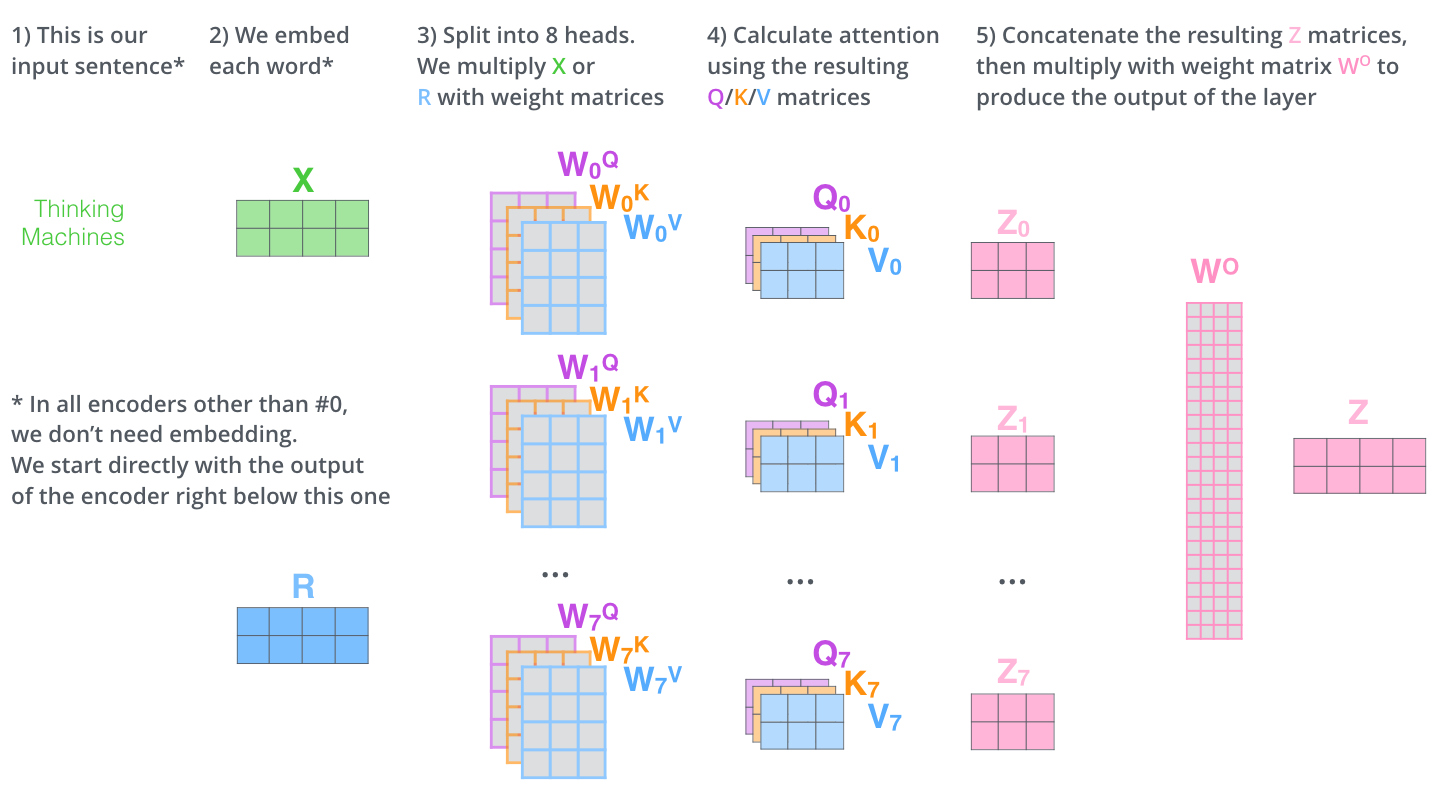

### Attention mask

It's important to note that the attention mechanism, as described, allows each token to "look" at the entire sequence, which is *undesirable for the decoder*. During generation, we produce one token per step. Access to future tokens during training would lead to information leakage and poor model quality. To prevent this, we apply an **autoregressive mask** during training, setting weights before softmax to $-\infty$ for future tokens, making their softmax probabilities zero.

In [ ]:
def get_masks(slen, lengths, causal):
    """
    Generate hidden states mask, and optionally an attention mask.
    """
    assert lengths.max().item() <= slen
    bs = lengths.size(0)
    alen = torch.arange(slen, dtype=torch.long, device=lengths.device)
    mask = alen < lengths[:, None]

    # attention mask is the same as mask, or triangular inferior attention (causal)
    if causal:
        attn_mask = alen[None, None, :].repeat(bs, slen, 1) <= alen[None, :, None]
    else:
        attn_mask = mask

    # sanity check
    assert mask.size() == (bs, slen)
    assert causal is False or attn_mask.size() == (bs, slen, slen)

    return mask, attn_mask

Example of usage:

In [ ]:
# Example usage
slen = 5  # Sequence length
lengths = torch.tensor([3, 5, 2])  # Example lengths
causal = True # Set to True for causal attention
mask, attn_mask = get_masks(slen, lengths, causal)
print("Mask (causal=True):\n", mask)
print("Attention Mask (causal=True):\n", attn_mask)

As shown in the figure, the attention mask is lower triangular.

In [ ]:
import matplotlib.pyplot as plt

# Select the first matrix in the batch (index 0)
matrix_to_plot = attn_mask[0].numpy()

# Create the plot
plt.imshow(~matrix_to_plot, cmap='gray', interpolation='nearest')
plt.colorbar()  # Add colorbar for better visualization
plt.title('Attention Mask (First Sample)')
plt.show()

## Transformer Layer

Before proceeding, note that for stability each encoder sub-layer (self-attention, feed-forward network) includes
*   a **residual connection**
*    and **layer normalization**.

Also, in the implementation below

*  **dropout** is also used after attention layers (not shown in the figure below).


Visualizing this for self-attention yields:


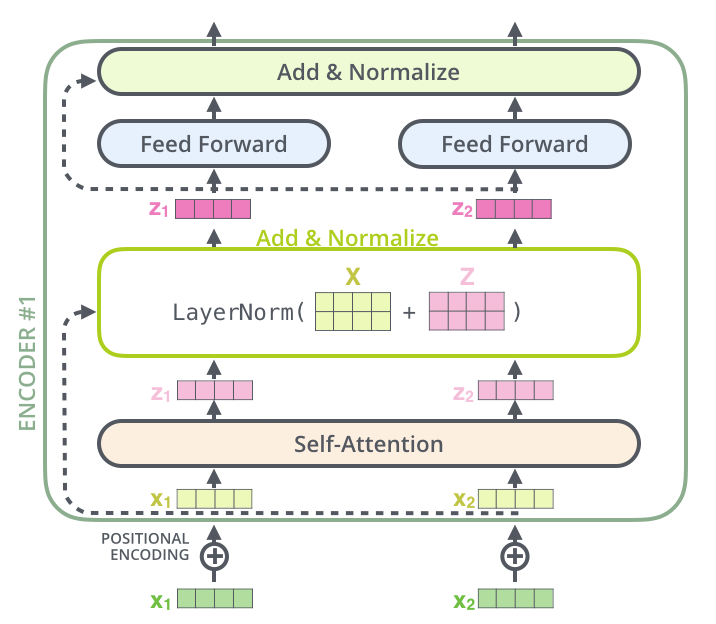

In [ ]:
class TransformerLayer(nn.Module):
    def __init__(self, params, is_encoder):
        """
        Transformer model (encoder or decoder).
        """
        super().__init__()

        self.is_encoder = is_encoder
        self.is_decoder = not is_encoder

        # model parameters
        self.dim = params["enc_emb_dim"] if is_encoder else params["dec_emb_dim"]  # 512 by default
        self.src_dim = params["enc_emb_dim"]
        self.hidden_dim = self.dim * 4  # 2048 by default
        self.n_heads = params["n_enc_heads"] if is_encoder else params["n_dec_heads"]  # 8 by default
        self.n_layers = params["n_enc_layers"] if is_encoder else params["n_dec_layers"]
        self.dropout = params["dropout"]
        self.attention_dropout = params["attention_dropout"]

        assert (
            self.dim % self.n_heads == 0
        ), "transformer dim must be a multiple of n_heads"

        # MultiHeadAttention
        self.self_attention = MultiHeadAttention(
            self.n_heads,
            self.dim,
            self.dim,
            dropout=self.attention_dropout,
        )

        # LayerNorm
        self.layer_norm1 = nn.LayerNorm(self.dim, eps=1e-12)

        # Decoder has another LayerNorm and MultiHeadAttention
        if self.is_decoder:
            self.layer_norm15 = nn.LayerNorm(self.dim, eps=1e-12)

            # encoder-decoder attention
            self.cross_attention = MultiHeadAttention(
                self.n_heads,
                self.dim,
                self.src_dim,
                dropout=self.attention_dropout,
            )

        # Feed-Forward Network
        self.ffn = TransformerFFN(
            self.dim,
            self.hidden_dim,
            self.dim,
            dropout=self.dropout,
        )

        # Layer Norm
        self.layer_norm2 = nn.LayerNorm(self.dim, eps=1e-12)

    def forward(self, x, attn_mask, src_mask, src_enc, use_cache=False, cache=None):
        tensor = x
        # self attention
        self.self_attention.cache = cache
        attn = self.self_attention(tensor, attn_mask, use_cache=use_cache)
        # dropout
        attn = F.dropout(attn, p=self.dropout, training=self.training)
        # residual connection
        output = tensor + attn
        # layer norm
        output = self.layer_norm1(output)

        # encoder attention (for decoder only)
        if self.is_decoder and src_enc is not None:
            self.cross_attention.cache = cache
            # encoder-decoder attention
            attn = self.cross_attention(tensor, src_mask, kv=src_enc, use_cache=use_cache)
            # dropout
            attn = F.dropout(attn, p=self.dropout, training=self.training)
            # residual connection
            output = output + attn
            # layer norm
            output = self.layer_norm15(output)

        # FFN
        output = output + self.ffn(output) # ffn + residual
        tensor = self.layer_norm2(output) # layer norm
        return tensor

The decoder has a similar structure:

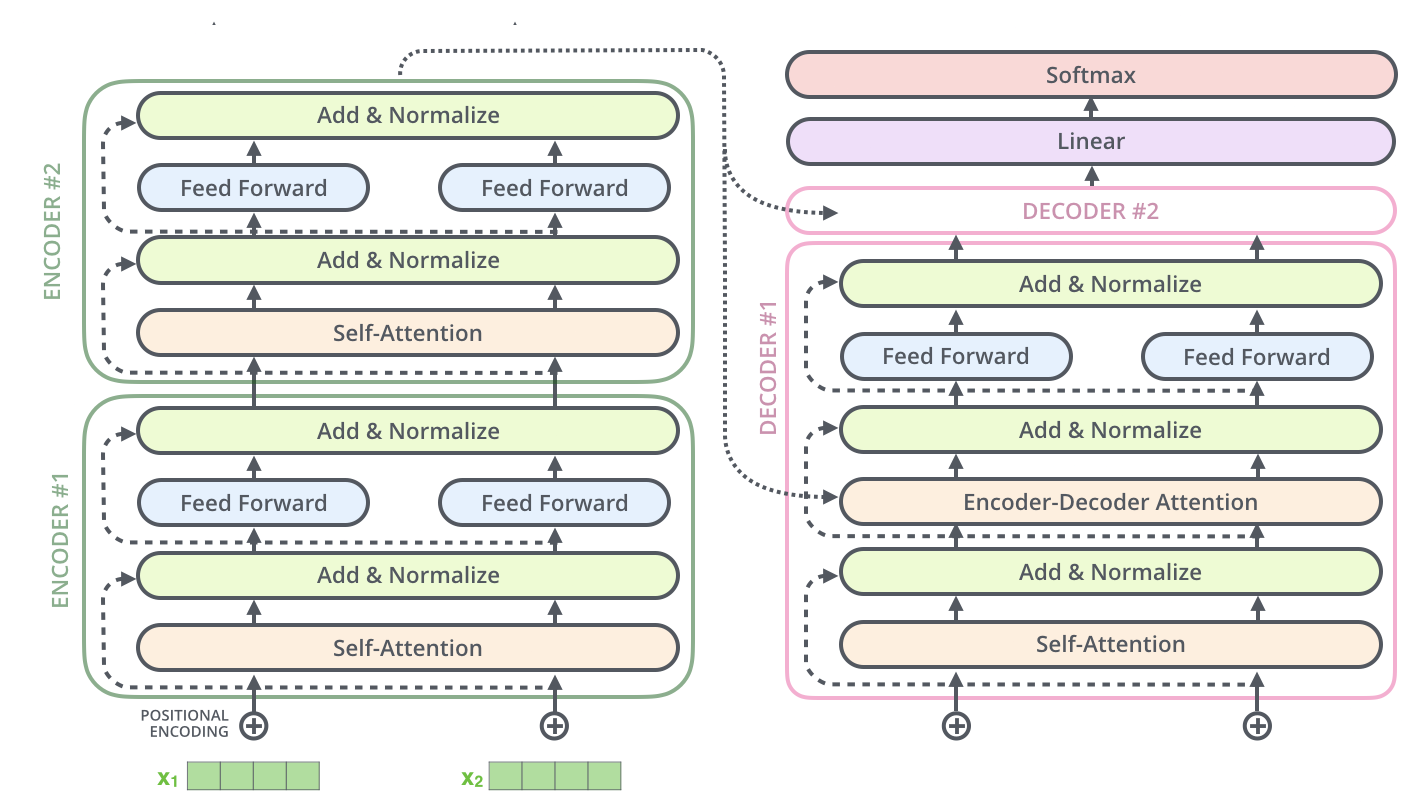